<a href="https://colab.research.google.com/github/jimkliew/SoKat/blob/master/AutoML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Poor Version of AutoML

## 1. Preparation (Manual)

In [0]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import datetime, timedelta

# show the plots
%matplotlib inline
# show all columns
pd.set_option('display.max_columns', None)
# set the backgraound
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":24,"axes.labelsize":18,
                             "xtick.labelsize":15,"ytick.labelsize":15}) 

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, TimeSeriesSplit, RepeatedKFold
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mlxtend.classifier import StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

/Users/ConradKang/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [0]:
total = pd.read_csv('AutoML.csv', parse_dates=['time'], index_col='time') # 1 hour & 3 windows

In [0]:
total.head()

,geo_ua_count,geo_nike_count,ua_price,nike_price,ua_stkv,nike_stkv,ua_tweet,nike_tweet,ua_twtcount,nike_twtcount,geo_count_ratio,price_ratio,tweet_diff,stkv_ratio,twtcount_ratio,return_ua,return_nike,return_diff,value_ua,value_nike,value_ratio
time,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,164.000000,172.000000,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.953488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2018-01-01 01:00:00,185.500000,146.000000,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.339244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2018-01-01 02:00:00,204.666667,162.333333,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.308214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2018-01-01 03:00:00,188.000000,151.333333,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,1.263766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2018-01-01 04:00:00,149.000000,169.000000,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,0.862176,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [0]:
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4028 entries, 2018-01-01 00:00:00 to 2018-06-17 19:00:00
Data columns (total 21 columns):
geo_ua_count       4028 non-null float64
geo_nike_count     4028 non-null float64
ua_price           1616 non-null float64
nike_price         1745 non-null float64
ua_stkv            4028 non-null float64
nike_stkv          4028 non-null float64
ua_tweet           1791 non-null float64
nike_tweet         1897 non-null float64
ua_twtcount        4028 non-null float64
nike_twtcount      4028 non-null float64
geo_count_ratio    4020 non-null float64
price_ratio        1529 non-null float64
tweet_diff         1626 non-null float64
stkv_ratio         1670 non-null float64
twtcount_ratio     2054 non-null float64
return_ua          1205 non-null float64
return_nike        1320 non-null float64
return_diff        1141 non-null float64
value_ua           4028 non-null int64
value_nike         4028 non-null int64
value_ratio        4028 non-null int64
dt

In [0]:
total.describe()

,geo_ua_count,geo_nike_count,ua_price,nike_price,ua_stkv,nike_stkv,ua_tweet,nike_tweet,ua_twtcount,nike_twtcount,geo_count_ratio,price_ratio,tweet_diff,stkv_ratio,twtcount_ratio,return_ua,return_nike,return_diff,value_ua,value_nike,value_ratio
count,4028.000000,4028.000000,1616.000000,1745.000000,4.028000e+03,4.028000e+03,1791.000000,1897.000000,4028.000000,4028.000000,4020.000000,1529.000000,1626.000000,1670.000000,2054.000000,1205.000000,1320.000000,1141.000000,4028.000000,4028.000000,4028.000000
mean,712.424901,549.070920,17.299657,67.758643,1.775010e+05,1.947991e+05,-0.013352,0.006308,5.142751,6.336643,2.171169,0.254188,-0.022074,10.318861,1.042214,0.000358,0.000201,0.000292,0.176018,0.194141,0.156405
std,734.201449,588.792470,2.723830,3.002144,3.886159e+05,3.693215e+05,0.084249,0.053166,20.055524,9.717299,16.660727,0.029686,0.108724,119.111070,2.923092,0.008636,0.004573,0.008167,0.380883,0.395587,0.363284
min,7.333333,0.000000,12.600000,62.330000,0.000000e+00,0.000000e+00,-0.819717,-0.437650,0.000000,0.000000,0.132952,0.199432,-1.009700,0.000000,0.000000,-0.047619,-0.020681,-0.066393,0.000000,0.000000,0.000000
25%,98.250000,81.333333,15.810000,65.816667,0.000000e+00,0.000000e+00,-0.040492,-0.013950,0.000000,0.000000,1.136801,0.240359,-0.055306,0.243973,0.384158,-0.003233,-0.001549,-0.003171,0.000000,0.000000,0.000000
50%,464.166667,355.000000,16.770833,67.266667,0.000000e+00,0.000000e+00,-0.003450,0.000850,0.333333,1.000000,1.305009,0.250434,-0.009696,0.677677,0.645111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1110.166667,822.416667,18.222500,68.670033,1.860000e+05,2.846961e+05,0.024842,0.020550,6.666667,11.000000,1.509274,0.269021,0.026600,1.251885,1.034339,0.003674,0.001813,0.003439,0.000000,0.000000,0.000000
max,3760.000000,4119.000000,24.520000,75.890000,6.699189e+06,2.675714e+06,0.549600,0.487450,682.333333,130.666667,549.000000,0.327392,0.668050,2899.290000,67.329545,0.063333,0.067029,0.063216,1.000000,1.000000,1.000000


In [0]:
# define the columns for future engineering with the help of above summary
fill_col = [6, 7, 12]
drop_col = [18, 19, 20]
tar_col = [20]
num = 3 # choose how many final models to choose to compare test accuracy

# button (email)

## 2. Feature Engineering

### Forward Filling

In [0]:
total.iloc[:, fill_col] = total.iloc[:, fill_col].fillna(method = 'ffill')

### Outliers Elimination

In [0]:
def outlier_eliminate(df):
    s_mean = df.replace([np.inf, -np.inf], np.nan).dropna().mean(axis = 0)
    s_std = df.replace([np.inf, -np.inf], np.nan).dropna().std(axis = 0)
    Q1 = s_mean - 3 * s_std
    Q2 = s_mean + 3 * s_std
    return df[~((df < Q1) | (df > Q2)).any(axis = 1)]

In [0]:
total = outlier_eliminate(total)

### Drop Missing Value

In [0]:
total.dropna(inplace = True)

### Drop the Target

In [0]:
X = total.drop(total.columns[drop_col], axis=1)
y = total.iloc[:,tar_col].astype('category').iloc[:,0]

In [0]:
print(X.shape)
print(y.shape)

(1013, 18)
(1013,)


## 3. EDA

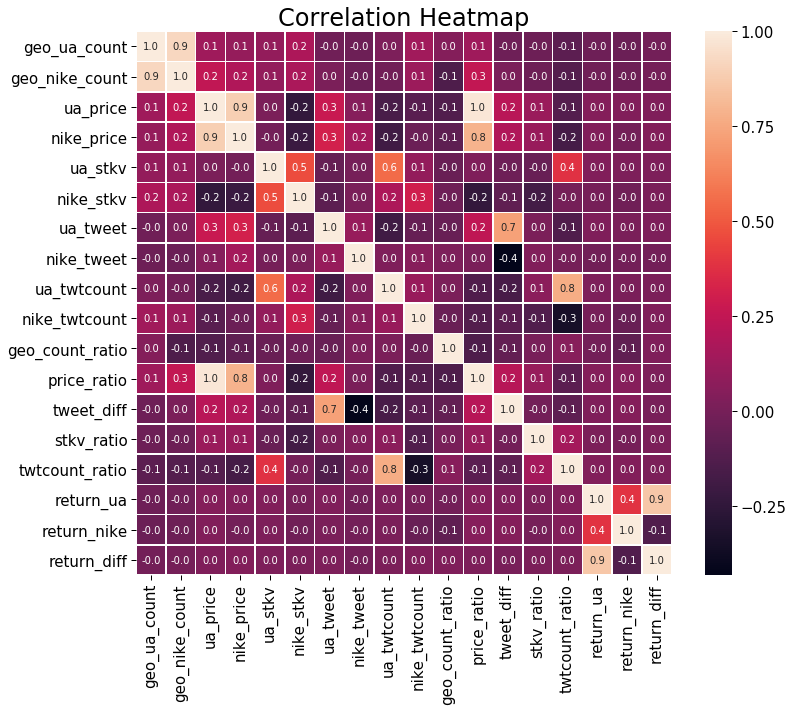

In [0]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)
plt.title('Correlation Heatmap', size = 24)
plt.show()

Number of ups:  510
Number of downs :  503


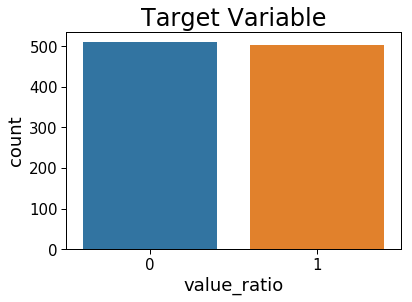

In [0]:
# No need for stratified sampling; know the random guessing accuracy (make y bold; SMOTE(..))
ax = sns.countplot(y, label="Count") 
ups, downs = y.value_counts()
plt.title('Target Variable')
print('Number of ups: ', ups)
print('Number of downs : ', downs)

## 4. Feature Selection

In [0]:
out_feature = int(0.5 * X.shape[1])
out_feature

9

### Variance Filtering

In [0]:
threshold = 0.8
vt = VarianceThreshold().fit(X)

feat_var_threshold = X.columns[vt.variances_ > threshold * (1 - threshold)]
feat_var_threshold

Index(['geo_ua_count', 'geo_nike_count', 'ua_price', 'nike_price', 'ua_stkv',
       'nike_stkv', 'ua_twtcount', 'nike_twtcount', 'geo_count_ratio',
       'stkv_ratio', 'twtcount_ratio'],
      dtype='object')

In [0]:
len(feat_var_threshold)

11

### Importance Ranking

In [0]:
modelr = RandomForestClassifier(random_state = 42)
modelr.fit(X, y)

feature_impr = pd.DataFrame(modelr.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_rf = feature_impr.sort_values("importance", ascending=False).head(out_feature).index
feat_imp_rf

Index(['ua_stkv', 'stkv_ratio', 'nike_stkv', 'nike_tweet', 'return_nike',
       'return_diff', 'twtcount_ratio', 'geo_ua_count', 'return_ua'],
      dtype='object')

In [0]:
modela = AdaBoostClassifier(random_state = 42)
modela.fit(X, y)

feature_impa = pd.DataFrame(modela.feature_importances_, index=X.columns, columns=["importance"])
feat_imp_ada = feature_impa.sort_values("importance", ascending=False).head(out_feature).index
feat_imp_ada

Index(['ua_tweet', 'geo_ua_count', 'stkv_ratio', 'nike_tweet', 'ua_twtcount',
       'geo_count_ratio', 'return_ua', 'tweet_diff', 'price_ratio'],
      dtype='object')

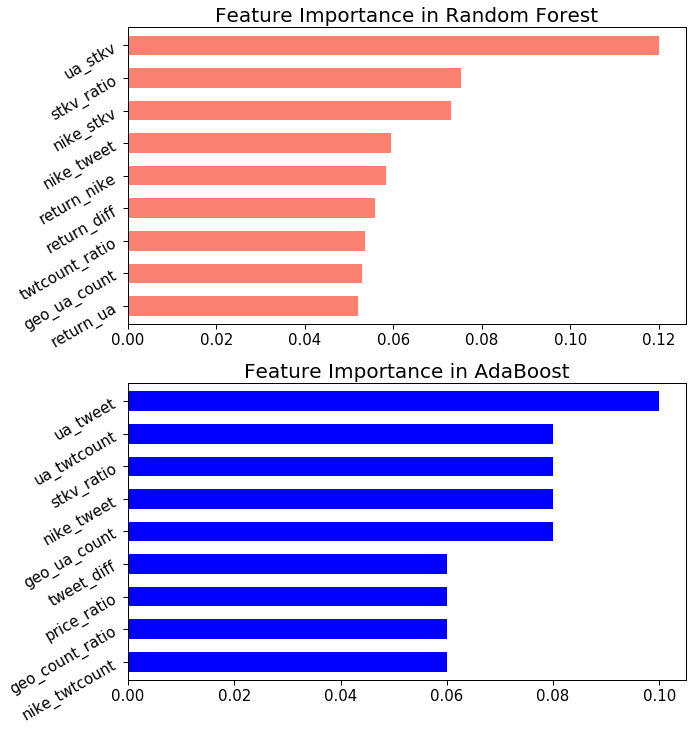

In [0]:
# important (feature importance)
fig, ax = plt.subplots(2, 1, figsize=(10,12))

pd.Series(modelr.feature_importances_, X.columns).sort_values(ascending=True).tail(out_feature).plot.barh(width=0.6, ax=ax[0], color='salmon')
ax[0].set_title('Feature Importance in Random Forest', fontsize=20)
ax[0].tick_params(axis='y', rotation=30)

pd.Series(modela.feature_importances_, X.columns).sort_values(ascending=True).tail(out_feature).plot.barh(width=0.6, ax=ax[1], color='blue')
ax[1].set_title('Feature Importance in AdaBoost', fontsize=20)
ax[1].tick_params(axis='y', rotation=30)

### SelectKBest with Chi-square

In [0]:
X_minmax = MinMaxScaler().fit_transform(X)
X_scored = SelectKBest(score_func=chi2, k='all').fit(X_minmax, y)
feature_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': X_scored.scores_
    })

feat_scored = feature_scoring.sort_values('score', ascending=False).head(out_feature)['feature'].values
feat_scored

array(['ua_stkv', 'nike_stkv', 'stkv_ratio', 'nike_twtcount',
       'return_diff', 'return_ua', 'twtcount_ratio', 'nike_price',
       'geo_count_ratio'], dtype=object)

### Recursive Feature Elimination

In [0]:
rfe = RFE(LogisticRegression(), out_feature)
rfe.fit(X, y)

feature_rfe_scoring = pd.DataFrame({
        'feature': X.columns,
        'score': rfe.ranking_
    })

feat_rfe = feature_rfe_scoring[feature_rfe_scoring['score'] == 1]['feature'].values
feat_rfe

array(['geo_nike_count', 'ua_price', 'nike_price', 'ua_twtcount',
       'nike_twtcount', 'geo_count_ratio', 'price_ratio', 'stkv_ratio',
       'twtcount_ratio'], dtype=object)

### Put All Things Together

In [0]:
# plot it!!! one name
features = np.hstack([
    feat_var_threshold,
    feat_imp_rf, 
    feat_imp_ada,
    feat_scored,
    feat_rfe
    ])

fc = pd.DataFrame(pd.Series(features).value_counts(), 
                  columns = ['count']).reset_index().rename(columns = {'index':'feature'})
fc

,feature,count
0,stkv_ratio,5
1,geo_count_ratio,4
2,twtcount_ratio,4
3,nike_stkv,3
4,nike_twtcount,3
5,return_ua,3
6,nike_price,3
7,geo_ua_count,3
8,ua_stkv,3
9,ua_twtcount,3


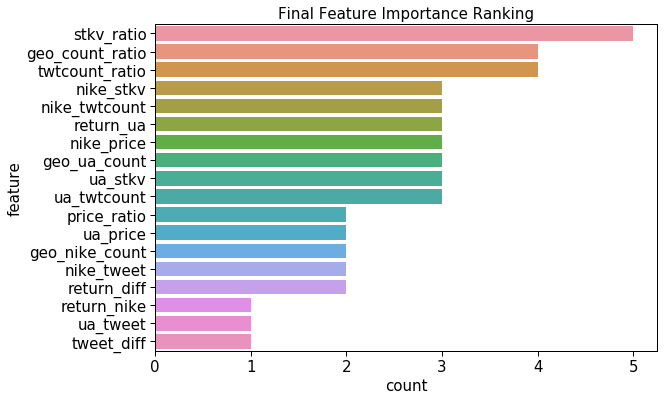

In [0]:
plt.figure(figsize = (9,6))
sns.barplot(x = 'count', y = 'feature', data = fc, orient = 'h')
plt.title('Final Feature Importance Ranking')
plt.show()

In [0]:
features = fc.feature[fc['count'] > 2].tolist()

print('Final features set:\n')
for f in features:
    print("\t-{}".format(f))

Final features set:

	-stkv_ratio
	-geo_count_ratio
	-twtcount_ratio
	-nike_stkv
	-nike_twtcount
	-return_ua
	-nike_price
	-geo_ua_count
	-ua_stkv
	-ua_twtcount


In [0]:
print(len(features))
X = X.ix[:, features]

10


## 5. Modeling

### 5.1 Preparation

In [0]:
random_state = 42
processors = -1
scoring = 'accuracy'
kfold = TimeSeriesSplit(n_splits=10)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify = y, random_state = random_state)
print('Training set features shape: {}'.format(X_train.shape))
print('Training set target shape: {}'. format((y_train).shape))

Training set features shape: (709, 10)
Training set target shape: (709,)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [0]:
# SMOTE
from imblearn.over_sampling import SMOTE
from collections import Counter

if (.5 < (y.value_counts()[0] / y.value_counts()[1]) < 2) != 1:
    sm = SMOTE(random_state = 42)
    X_train, y_train = sm.fit_resample(X_train, y_train)
    print('Resampled dataset shape %s' % Counter(y_train))

### 5.2 Simple Modeling

#### Cross Validation

In [0]:
classifiers = [
    SVC(random_state = random_state),
    DecisionTreeClassifier(random_state = random_state),
    RandomForestClassifier(random_state = random_state),
    KNeighborsClassifier(),
    LogisticRegression(random_state = random_state),
    LDA(), 
    QDA(), 
    GaussianNB(), 
    MLPClassifier(random_state = random_state),
    AdaBoostClassifier(random_state = random_state),
    GradientBoostingClassifier(random_state = random_state),
    BaggingClassifier(random_state = random_state)
]

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y_train, scoring = "accuracy", cv = kfold))

cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cla_names = [
    "Support Vector Machine","Decision Tree","Random Forest","KNeighbors",
    "Logistic Regression","Linear Discriminant Analysis",
    "Quadratic Discriminant Analysis","Naive Bayes",
    "Neural Network","AdaBoosting","Gradient Boosting", "Bagging Trees"
]
    
cv_res = pd.DataFrame({"Method": cla_names,
                       "CrossValMeans": cv_means,
                       "CrossValerrors": cv_std})

cv_res = cv_res.sort_values(['CrossValMeans'],ascending=False).reset_index(drop=True)
cv_res

,Method,CrossValMeans,CrossValerrors
0,Neural Network,0.618750,0.058128
1,Logistic Regression,0.612500,0.058380
2,Linear Discriminant Analysis,0.606250,0.054486
3,Gradient Boosting,0.598437,0.068126
4,Support Vector Machine,0.587500,0.084201
5,Bagging Trees,0.581250,0.059621
6,Decision Tree,0.559375,0.081130
7,Random Forest,0.559375,0.072214
8,KNeighbors,0.557813,0.043103
9,Quadratic Discriminant Analysis,0.556250,0.064877


In [0]:
pl = pd.DataFrame(data = cv_results, index = cla_names)
pl = pl.T

Text(0.5, 1.0, 'Cross Validation Accuracy')

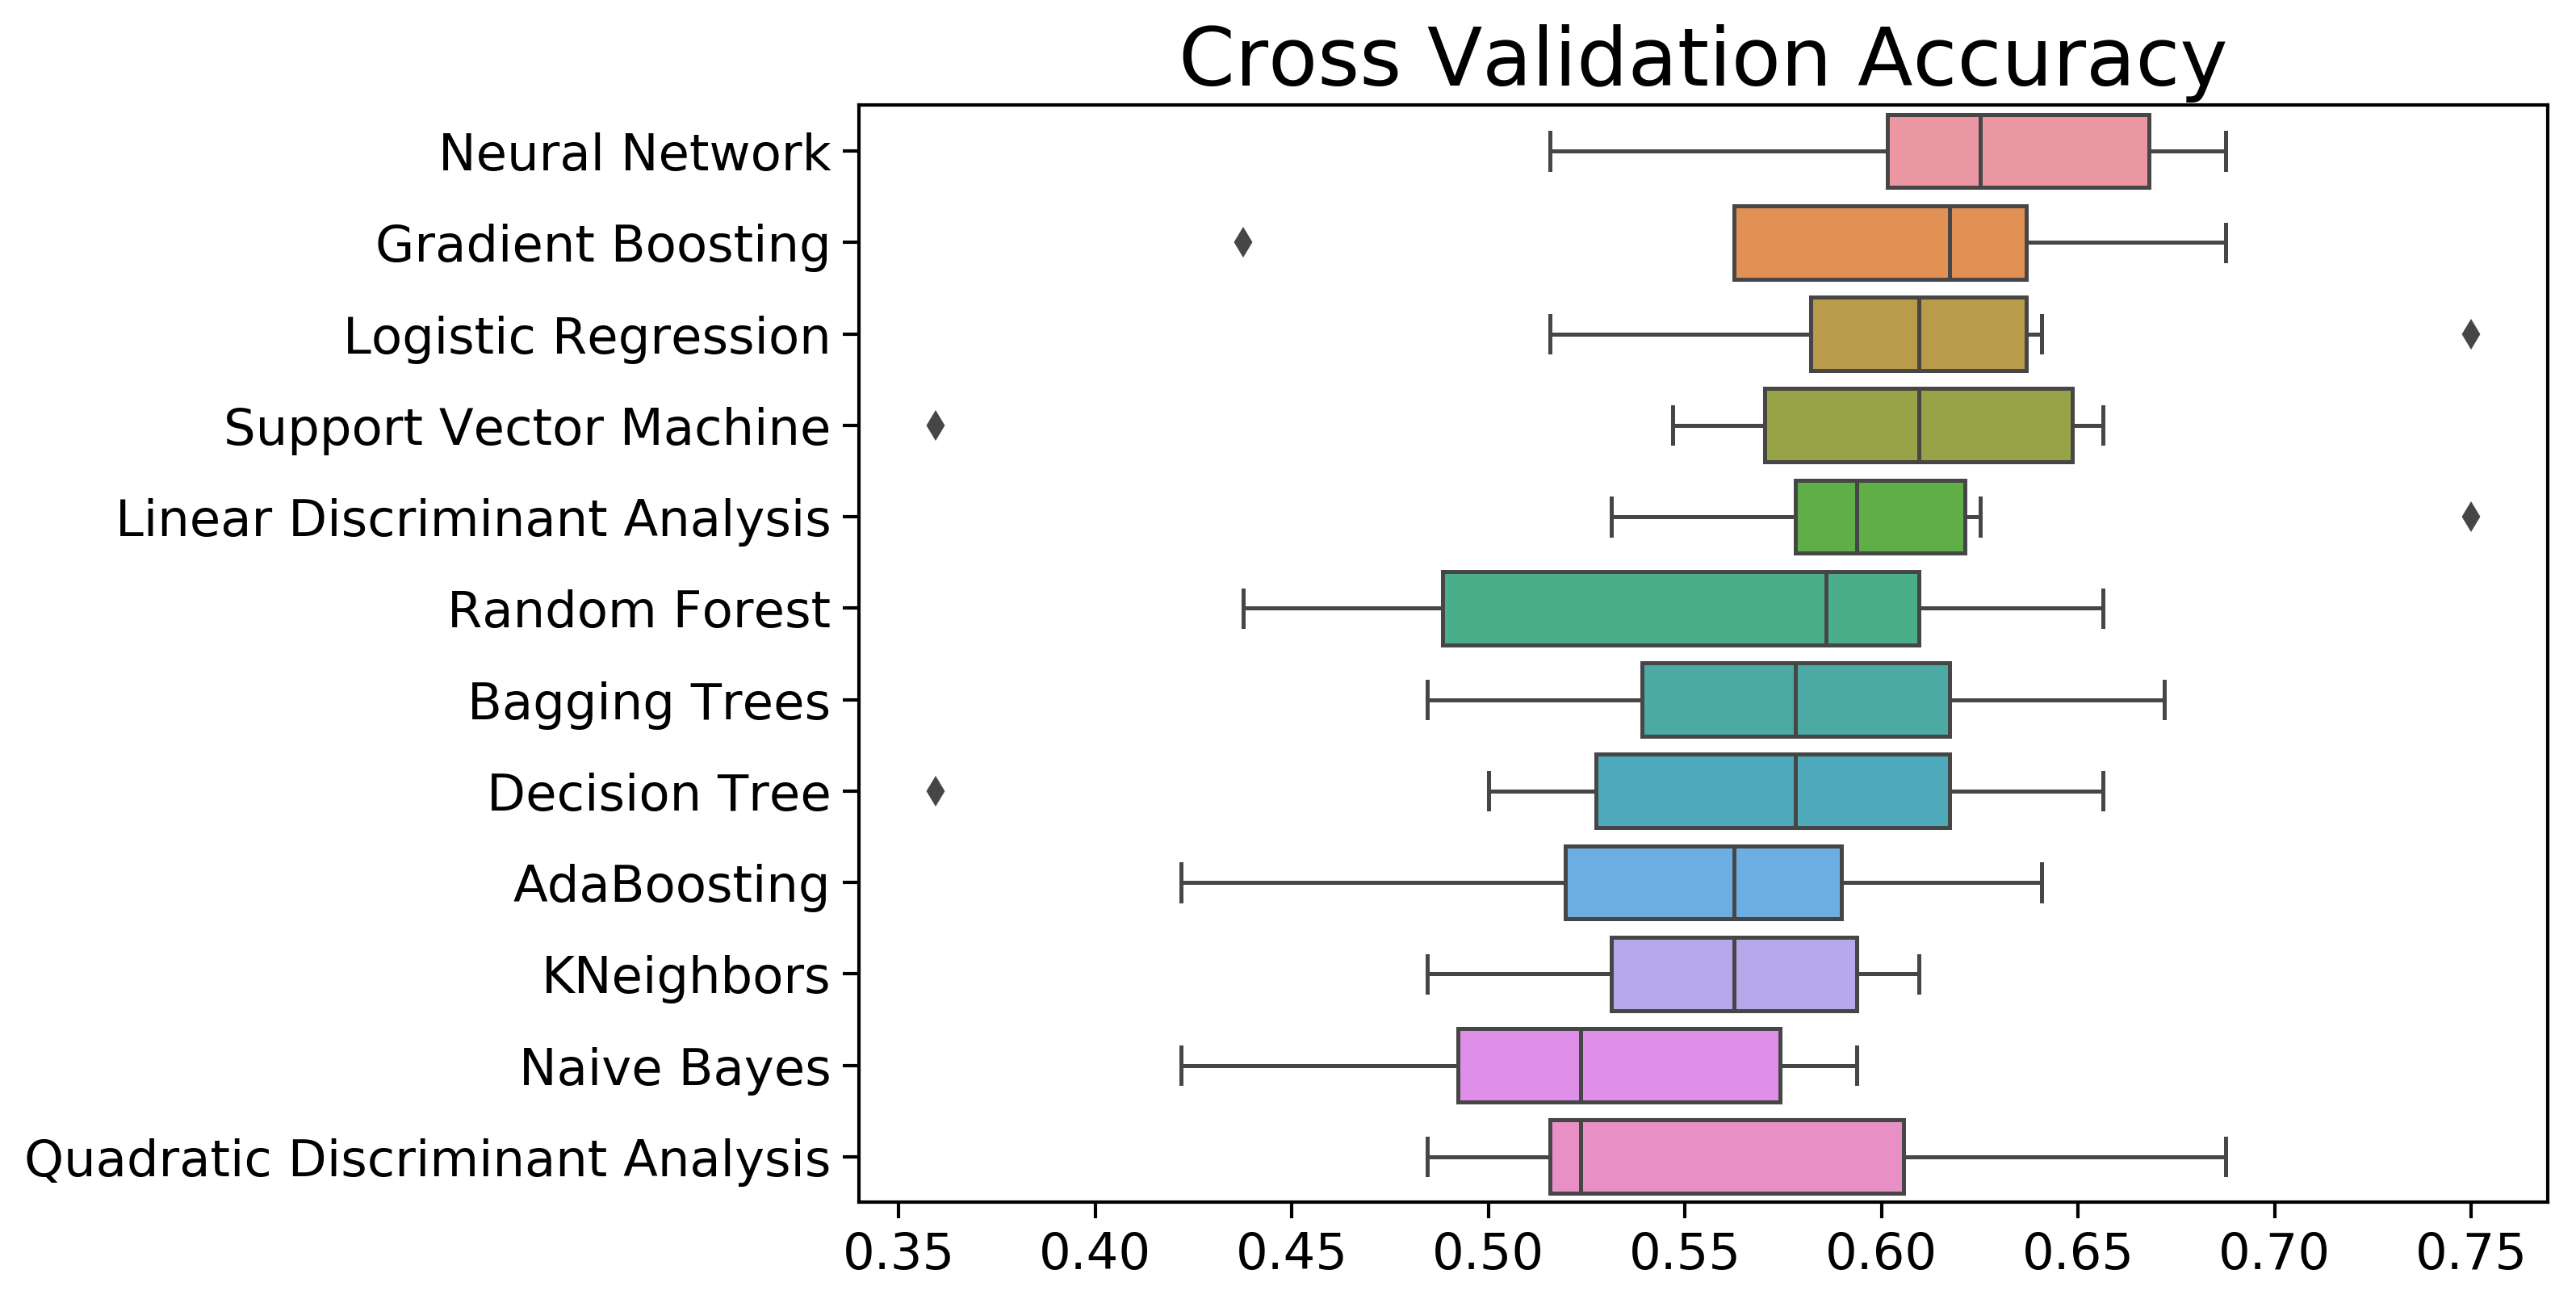

In [0]:
# Barplot
plt.figure(figsize = (9,6), dpi = 300)
sns.boxplot(data = pl[pl.median().sort_values(ascending=False).index], orient = 'h')
plt.title('Cross Validation Accuracy')

#### Using Testing Set

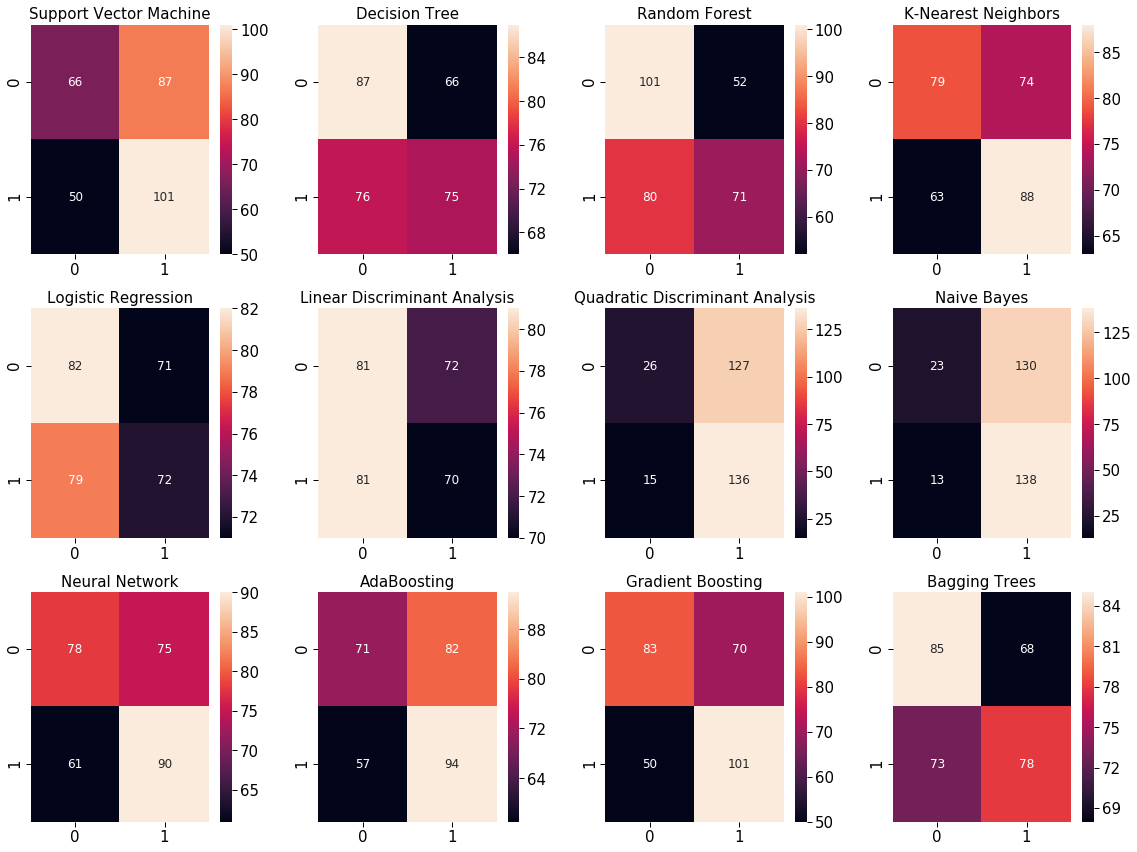

In [0]:
# Confusion Matrix
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":15,"axes.labelsize":15,"xtick.labelsize":15,"ytick.labelsize":15})

f, ax = plt.subplots(3,4,figsize=(16,12))

acc=[]

model=SVC(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[0,0],annot=True,fmt='d')
ax[0,0].set_title('Support Vector Machine')

cart=DecisionTreeClassifier(random_state = random_state)
model=cart
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[0,1],annot=True,fmt='d')
ax[0,1].set_title('Decision Tree')

model=RandomForestClassifier(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[0,2],annot=True,fmt='d')
ax[0,2].set_title('Random Forest')

model=KNeighborsClassifier()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[0,3],annot=True,fmt='d')
ax[0,3].set_title('K-Nearest Neighbors')

model=LogisticRegression(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[1,0],annot=True,fmt='d')
ax[1,0].set_title('Logistic Regression')

model=LDA()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[1,1],annot=True,fmt='d')
ax[1,1].set_title('Linear Discriminant Analysis')

model=QDA()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[1,2],annot=True,fmt='d')
ax[1,2].set_title('Quadratic Discriminant Analysis')

model=GaussianNB()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[1,3],annot=True,fmt='d')
ax[1,3].set_title('Naive Bayes')

model=MLPClassifier(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[2,0],annot=True,fmt='d')
ax[2,0].set_title('Neural Network')

model=AdaBoostClassifier(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[2,1],annot=True,fmt='d')
ax[2,1].set_title('AdaBoosting')

model=GradientBoostingClassifier(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[2,2],annot=True,fmt='d')
ax[2,2].set_title('Gradient Boosting')

model=BaggingClassifier(random_state = random_state)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
acc.append(accuracy_score(y_test,y_pred))
sns.heatmap(confusion_matrix(y_test,y_pred),ax=ax[2,3],annot=True,fmt='d')
ax[2,3].set_title('Bagging Trees')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.tight_layout()
plt.show()

In [0]:
accdf = pd.DataFrame({"Accuracy":acc,
                      "Algorithm":["SVM","DT","RF","KNN",
                                   "LR","LDA",
                                   "QDA","NB","NN",
                                   "AdaBoost","GBM","Bagging"]})

accdf = accdf.sort_values(['Accuracy'],ascending=False).reset_index(drop=True)
accdf

,Accuracy,Algorithm
0,0.605263,GBM
1,0.565789,RF
2,0.552632,NN
3,0.549342,SVM
4,0.549342,KNN
5,0.542763,AdaBoost
6,0.536184,Bagging
7,0.532895,DT
8,0.532895,QDA
9,0.529605,NB


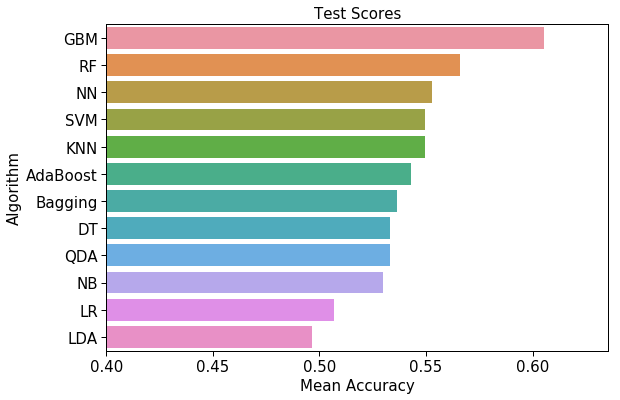

In [0]:
plt.figure(figsize = (9,6))
sns.barplot("Accuracy", "Algorithm", data = accdf)
plt.xlabel("Mean Accuracy")
plt.title("Test Scores")
plt.xlim(left = 0.4)
plt.show()

### 5.3 Hyperparameter Tuning (Evaluating Accuracy)

In [0]:
lr_grid = GridSearchCV(
    estimator = LogisticRegression(random_state=random_state),
    param_grid = {
        'penalty': ['l1', 'l2'],
        'C': [0.001,0.01, 0.1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lr_grid.fit(X_train, y_train)

lda_grid = GridSearchCV(
    estimator = LDA(),
    param_grid = {
        'solver': ['svd', 'lsqr'],
        'n_components': [None, 2, 5]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

lda_grid.fit(X_train, y_train)

qda_grid = GridSearchCV(
    estimator = QDA(),
    param_grid = {
        'priors': [None, 0, 1],
        'reg_param': [0.2, 0.3, 0.4]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

qda_grid.fit(X_train, y_train)

bag_grid = RandomizedSearchCV(
    estimator = BaggingClassifier(base_estimator=cart, warm_start=True, random_state=random_state),
    param_distributions = {
        'n_estimators': [200, 500, 1000],
        'max_samples': [0.1, 0.3, 0.5],
        'max_features': [0.3, 0.5, 0.7]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

bag_grid.fit(X_train, y_train)

rf_grid = RandomizedSearchCV(
    estimator = RandomForestClassifier(warm_start=True, random_state=random_state),
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'criterion': ['gini', 'entropy'],
        'max_depth': [6, 8, 10],
        'max_features': ['sqrt', 'log2']
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

rf_grid.fit(X_train, y_train)

ada_grid = RandomizedSearchCV(
    estimator = AdaBoostClassifier(random_state=random_state),
    param_distributions = {
        'algorithm': ['SAMME', 'SAMME.R'],
        'n_estimators': [200, 500, 1000],
        'learning_rate': [0.001, 0.01, 0.1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

ada_grid.fit(X_train, y_train)

gbm_grid = RandomizedSearchCV(
    estimator = GradientBoostingClassifier(warm_start=True, random_state=random_state),
    param_distributions = {
        'n_estimators': [100, 200, 500],
        'max_depth': [8, 10, 12],
        'max_features': [0.1, 0.3, 0.5],
        'learning_rate': [0.01, 0.1, 1]
    }, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors)

gbm_grid.fit(X_train, y_train)

xgb_grid = RandomizedSearchCV(
    estimator = XGBClassifier(objective = 'binary:logistic', seed = random_state), 
    param_distributions = {
    'learning_rate': [0.01, 0.1, 1], 
    'n_estimators': [50, 100, 200],
    'subsample': [0.1, 0.3, 0.5]
}, 
    n_iter = 10, 
    cv = kfold, 
    scoring = scoring, 
    n_jobs = processors,
    verbose = False)

xgb_grid.fit(X_train, y_train)

lgb_grid = GridSearchCV(
    estimator = LGBMClassifier(objective = 'binary'),
    param_grid = {
        'num_leaves': [20, 30, 40],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [20, 40, 60]
    },
    cv = kfold,
    scoring = scoring, 
    n_jobs = processors)

lgb_grid.fit(X_train, y_train)

# create sub models according to the best models above
clf1 = lr_grid.best_estimator_
clf2 = lda_grid.best_estimator_
clf3 = qda_grid.best_estimator_
clf4 = bag_grid.best_estimator_
clf5 = rf_grid.best_estimator_
clf6 = ada_grid.best_estimator_
clf7 = gbm_grid.best_estimator_
clf8 = xgb_grid.best_estimator_
clf9 = lgb_grid.best_estimator_

In [0]:
lr = LogisticRegression()

sclf = StackingClassifier(classifiers = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9], 
                          use_probas = True, average_probas = False,
                          meta_classifier = lr)

print('10-fold cross validation:\n')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, sclf], 
                      ['LR', 
                       'LDA', 
                       'QDA',
                       'Bagging Trees',
                       'Random Forest',
                       'Adaboost',
                       'GBM',
                       'XGBoost',
                       'LightGBM',
                       'Stacking']):

    scores = cross_val_score(clf, X_train, y_train, cv = kfold, scoring = scoring)
    print("ACC: %0.3f (+/- %0.3f) [%s]" 
          % (scores.mean(), scores.std(), label))

10-fold cross validation:

ACC: 0.614 (+/- 0.052) [LR]
ACC: 0.606 (+/- 0.054) [LDA]
ACC: 0.598 (+/- 0.067) [QDA]
ACC: 0.609 (+/- 0.058) [Bagging Trees]
ACC: 0.617 (+/- 0.057) [Random Forest]
ACC: 0.614 (+/- 0.083) [Adaboost]
ACC: 0.594 (+/- 0.071) [GBM]
ACC: 0.600 (+/- 0.068) [XGBoost]
ACC: 0.603 (+/- 0.078) [LightGBM]
ACC: 0.588 (+/- 0.064) [Stacking]


In [0]:
# Create sub models
estimators = [
    ('lr',clf1),
    ('lda',clf2),
    ('qda',clf3),
    ('bag',clf4),
    ('rf',clf5),
    ('ada',clf6),
    ('gbm',clf7),
    ('xgb',clf8),
    ('lgb',clf9)
]

# Create the ensemble model
ensemble = VotingClassifier(estimators, voting = 'soft')
results = cross_val_score(ensemble, X_train, y_train, cv = kfold, scoring = scoring, n_jobs = processors)

print("Ensemble:")
print("="*30)
print("({0:.3f}) +/- ({1:.3f})".format(results.mean(), results.std()))

Ensemble:
(0.620) +/- (0.058)


In [0]:
acc_list = [
    lr_grid.best_score_,
    lda_grid.best_score_,
    qda_grid.best_score_,
    bag_grid.best_score_,
    rf_grid.best_score_,
    ada_grid.best_score_,
    gbm_grid.best_score_,
    xgb_grid.best_score_,
    lgb_grid.best_score_,
    scores.mean(),
    results.mean()
]

name_list = [
    'LR', 
    'LDA', 
    'QDA',
    'Bagging Trees',
    'Random Forest',
    'Adaboost',
    'GBM',
    'XGBoost',
    'LightGBM',
    'Stacking',
    'Ensemble'
]

mod_list = [clf1, clf2, clf3, clf4, clf5, clf6, clf7, clf8, clf9, sclf, ensemble]

mod_df = pd.DataFrame(list(zip(name_list, mod_list, acc_list)), columns =['Name', 'Model', 'Accuracy']) 

In [0]:
print("Best Models:", list(mod_df.nlargest(num, 'Accuracy').Name))

Best Models: ['Ensemble', 'Random Forest', 'LR']


In [0]:
models = mod_df.nlargest(num, 'Accuracy').Model # best model for each evaluation method

print("Final Accuracy Comparison:")
print("="*30)

for label, mod in zip(mod_df.nlargest(num, 'Accuracy').Name, mod_df.nlargest(num, 'Accuracy').Model):
    mod.fit(X_train, y_train)
    preds_test = mod.predict(X_test)
    accuracy = float(np.sum(preds_test == y_test)) / pd.Series(y_test).shape[0]
    
    print("%s: %0.3f " 
          % (label, accuracy))

Final Accuracy Comparison:
Ensemble: 0.572 
Random Forest: 0.566 
LR: 0.520 
